# BGE-M3 ONNX Performance Analysis

This notebook analyzes performance test results for BGE-M3 ONNX implementation across different programming languages (Python, C#/.NET, Java) and execution providers (CPU, CUDA).

## System Specifications

- **Operating System**: Windows 11 Pro 64-bit (10.0, Build 26100)
- **System Manufacturer**: Gigabyte Technology Co., Ltd. B650 AERO G
- **CPU**: AMD Ryzen 7 7800X3D 8-Core Processor
- **GPU**: NVIDIA GeForce RTX 4080 SUPER
- **RAM**: G. Skill Trident Z5 Neo 32768MB RAM

## Library Versions

- **Python**: onnxruntime-gpu: 1.22.0, onnxruntime_extensions: 0.14.0, FlagEmbedding 1.3.4
- **C#/.NET**: Microsoft.ML.OnnxRuntime.Gpu: 1.22.0, Microsoft.ML.OnnxRuntime.Extensions: 0.14.0
- **Java**: onnxruntime_gpu: 1.22.0, onnxruntime-extensions: 0.13.0

## Test Dataset

All tests were performed on a dataset of 1000 diverse texts with varying lengths, languages, and domains.

In [ ]:
%pip install matplotlib seaborn pandas numpy

In [41]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_performance_data():
    results = {}
    
    files = {
        'Python': 'onnx/performance_python.json',
        'C#/.NET': 'onnx/performance_dotnet.json', 
        'Java': 'onnx/performance_java.json'
    }
    
    for lang, filepath in files.items():
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
                results[lang] = data
                print(f"Loaded {lang} results from {filepath}")
        except FileNotFoundError:
            print(f"Could not find {filepath}")
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    return results

performance_data = load_performance_data()

Loaded Python results from onnx/performance_python.json
Loaded C#/.NET results from onnx/performance_dotnet.json
Loaded Java results from onnx/performance_java.json


In [42]:
# Extract performance metrics for visualization
def extract_metrics(data):
    metrics = []
    
    for language, lang_data in data.items():
        scenarios = lang_data.get('scenarios', {})
        
        for scenario_name, scenario_data in scenarios.items():
            if scenario_data.get('error'):
                continue
                
            provider = 'CUDA' if 'cuda' in scenario_name.lower() else 'CPU'
            
            if 'transformers' in scenario_name:
                impl_type = 'Transformers'
            else:
                impl_type = 'ONNX'
            
            metrics.append({
                'Language': language,
                'Provider': provider,
                'Implementation': impl_type,
                'Scenario': scenario_name,
                'Avg_Latency_ms': scenario_data.get('average_latency_ms', 0),
                'Throughput_texts_per_sec': scenario_data.get('throughput_texts_per_second', 0),
                'Init_Time_sec': scenario_data.get('initialization_time_seconds', 0),
                'Total_Time_sec': scenario_data.get('total_time_seconds', 0),
                'Successful_Embeddings': scenario_data.get('successful_embeddings', 0)
            })
    
    return pd.DataFrame(metrics)

df = extract_metrics(performance_data)
print(f"\nExtracted {len(df)} performance measurements:")
print(df[['Language', 'Provider', 'Implementation', 'Avg_Latency_ms', 'Throughput_texts_per_sec']].to_string(index=False))


Extracted 7 performance measurements:
Language Provider Implementation  Avg_Latency_ms  Throughput_texts_per_sec
  Python      CPU   Transformers       21.375000                 46.779250
  Python      CPU           ONNX       31.363979                 31.882694
  Python     CUDA           ONNX        6.949999                143.884921
 C#/.NET      CPU           ONNX       30.740513                 32.526330
 C#/.NET     CUDA           ONNX        7.320441                136.582679
    Java     CUDA           ONNX        6.867000                145.623999
    Java      CPU           ONNX       31.212000                 32.031776


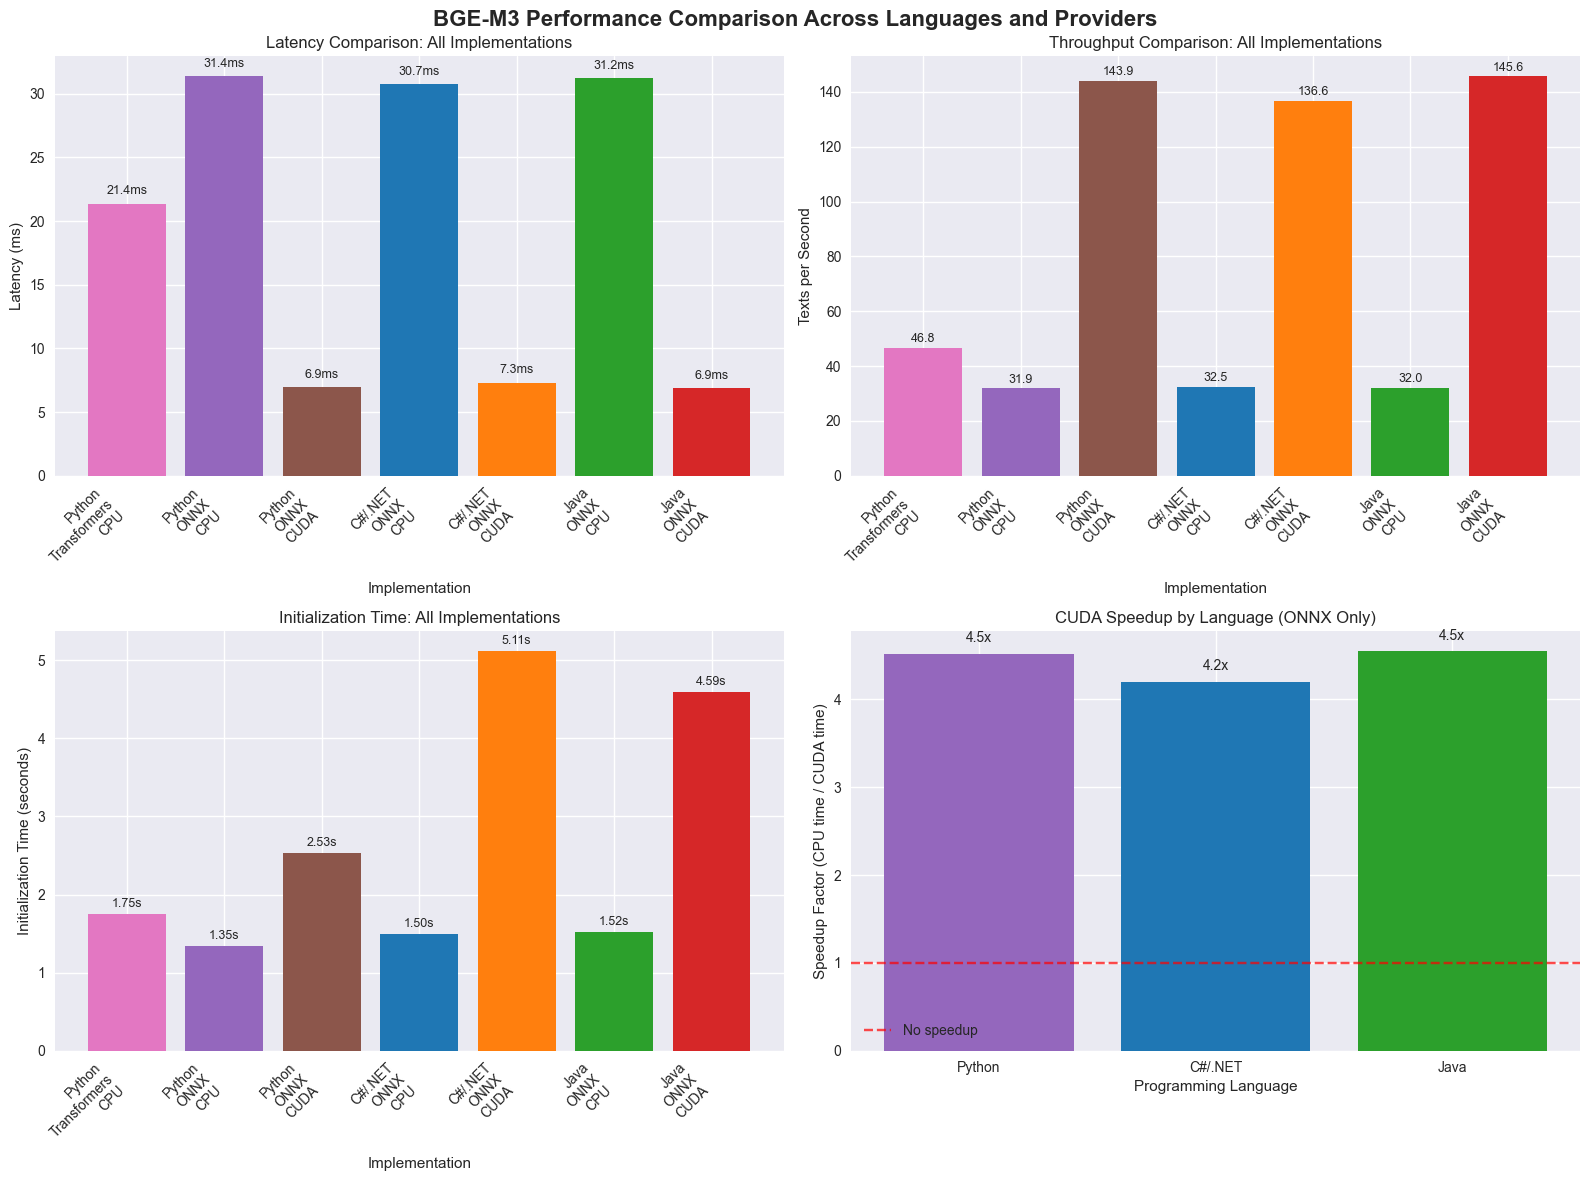

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('BGE-M3 Performance Comparison Across Languages and Providers', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]

ordered_implementations = [
   'Python_Transformers_CPU',
   'Python_ONNX_CPU', 
   'Python_ONNX_CUDA',
   'C#/.NET_ONNX_CPU',
   'C#/.NET_ONNX_CUDA', 
   'Java_ONNX_CPU',
   'Java_ONNX_CUDA'
]

color_map = {
   'Python_Transformers_CPU': '#e377c2',
   'Python_ONNX_CPU': '#9467bd',
   'Python_ONNX_CUDA': '#8c564b',
   'C#/.NET_ONNX_CPU': '#1f77b4',
   'C#/.NET_ONNX_CUDA': '#ff7f0e', 
   'Java_ONNX_CPU': '#2ca02c',
   'Java_ONNX_CUDA': '#d62728'
}

data_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_Transformers_{row['Provider']}"
   data_mapping[key] = row['Avg_Latency_ms']

ordered_latencies = []
ordered_colors = []
display_labels = []

for impl in ordered_implementations:
   if impl in data_mapping:
       ordered_latencies.append(data_mapping[impl])
       ordered_colors.append(color_map[impl])
       display_labels.append(impl.replace('_', '\n'))

bars1 = ax1.bar(range(len(display_labels)), ordered_latencies, color=ordered_colors)
ax1.set_title('Latency Comparison: All Implementations')
ax1.set_ylabel('Latency (ms)')
ax1.set_xlabel('Implementation')
ax1.set_xticks(range(len(display_labels)))
ax1.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, latency in zip(bars1, ordered_latencies):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{latency:.1f}ms', ha='center', va='bottom', fontsize=9)

ax2 = axes[0, 1]

throughput_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_Transformers_{row['Provider']}"
   throughput_mapping[key] = row['Throughput_texts_per_sec']

ordered_throughput = []
for impl in ordered_implementations:
   if impl in throughput_mapping:
       ordered_throughput.append(throughput_mapping[impl])

bars2 = ax2.bar(range(len(display_labels)), ordered_throughput, color=ordered_colors)
ax2.set_title('Throughput Comparison: All Implementations')
ax2.set_ylabel('Texts per Second')
ax2.set_xlabel('Implementation')
ax2.set_xticks(range(len(display_labels)))
ax2.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, throughput in zip(bars2, ordered_throughput):
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{throughput:.1f}', ha='center', va='bottom', fontsize=9)

ax3 = axes[1, 0]

init_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_Transformers_{row['Provider']}"
   init_mapping[key] = row['Init_Time_sec']

ordered_init = []
for impl in ordered_implementations:
   if impl in init_mapping:
       ordered_init.append(init_mapping[impl])

bars3 = ax3.bar(range(len(display_labels)), ordered_init, color=ordered_colors)
ax3.set_title('Initialization Time: All Implementations')
ax3.set_ylabel('Initialization Time (seconds)')
ax3.set_xlabel('Implementation')
ax3.set_xticks(range(len(display_labels)))
ax3.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, init_time in zip(bars3, ordered_init):
   height = bar.get_height()
   ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{init_time:.2f}s', ha='center', va='bottom', fontsize=9)

ax4 = axes[1, 1]

speedup_data = []
speedup_colors = []

for lang in ['Python', 'C#/.NET', 'Java']:
   lang_onnx_df = df[(df['Language'] == lang) & (df['Implementation'] == 'ONNX')]
   cpu_latency = lang_onnx_df[lang_onnx_df['Provider'] == 'CPU']['Avg_Latency_ms'].values
   cuda_latency = lang_onnx_df[lang_onnx_df['Provider'] == 'CUDA']['Avg_Latency_ms'].values
   
   if len(cpu_latency) > 0 and len(cuda_latency) > 0 and cuda_latency[0] > 0:
       speedup = cpu_latency[0] / cuda_latency[0]
       speedup_data.append(speedup)
       
       if lang == 'Python':
           speedup_colors.append('#9467bd')
       elif lang == 'C#/.NET':
           speedup_colors.append('#1f77b4')
       elif lang == 'Java':
           speedup_colors.append('#2ca02c')

if speedup_data:
   language_labels = ['Python', 'C#/.NET', 'Java'][:len(speedup_data)]
   bars4 = ax4.bar(language_labels, speedup_data, color=speedup_colors)
   ax4.set_title('CUDA Speedup by Language (ONNX Only)')
   ax4.set_ylabel('Speedup Factor (CPU time / CUDA time)')
   ax4.set_xlabel('Programming Language')
   ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
   ax4.legend()
   
   for bar in bars4:
       height = bar.get_height()
       ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               f'{height:.1f}x', ha='center', va='bottom', fontsize=10)
else:
   ax4.text(0.5, 0.5, 'No CUDA speedup data available', 
            ha='center', va='center', transform=ax4.transAxes)
   ax4.set_title('CUDA Speedup by Language (No Data)')

plt.tight_layout()
plt.show()

In [44]:
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

summary_df = df.copy()
summary_df['Latency (ms)'] = summary_df['Avg_Latency_ms'].round(1)
summary_df['Throughput (texts/sec)'] = summary_df['Throughput_texts_per_sec'].round(1)
summary_df['Init Time (sec)'] = summary_df['Init_Time_sec'].round(2)

display_cols = ['Language', 'Provider', 'Implementation', 'Latency (ms)', 'Throughput (texts/sec)', 'Init Time (sec)']
print(summary_df[display_cols].to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

if not df.empty:
    best_latency = df.loc[df['Avg_Latency_ms'].idxmin()]
    best_throughput = df.loc[df['Throughput_texts_per_sec'].idxmax()]
    
    print(f"⚡ Lowest Latency: {best_latency['Language']} {best_latency['Provider']} ({best_latency['Avg_Latency_ms']:.1f}ms)")
    print(f"🚀 Highest Throughput: {best_throughput['Language']} {best_throughput['Provider']} ({best_throughput['Throughput_texts_per_sec']:.1f} texts/sec)")
    
    cuda_results = df[df['Provider'] == 'CUDA']
    cpu_results = df[df['Provider'] == 'CPU']
    
    if not cuda_results.empty and not cpu_results.empty:
        avg_cuda_latency = cuda_results['Avg_Latency_ms'].mean()
        avg_cpu_latency = cpu_results['Avg_Latency_ms'].mean()
        overall_speedup = avg_cpu_latency / avg_cuda_latency if avg_cuda_latency > 0 else 0
        
        print(f"📊 Average CUDA Speedup: {overall_speedup:.1f}x faster than CPU")
        print(f"💾 CPU Average Latency: {avg_cpu_latency:.1f}ms")
        print(f"⚡ CUDA Average Latency: {avg_cuda_latency:.1f}ms")
else:
    print("No performance data available for analysis.")


PERFORMANCE SUMMARY
Language Provider Implementation  Latency (ms)  Throughput (texts/sec)  Init Time (sec)
  Python      CPU   Transformers          21.4                    46.8             1.75
  Python      CPU           ONNX          31.4                    31.9             1.35
  Python     CUDA           ONNX           6.9                   143.9             2.53
 C#/.NET      CPU           ONNX          30.7                    32.5             1.50
 C#/.NET     CUDA           ONNX           7.3                   136.6             5.11
    Java     CUDA           ONNX           6.9                   145.6             4.59
    Java      CPU           ONNX          31.2                    32.0             1.52

KEY INSIGHTS
⚡ Lowest Latency: Java CUDA (6.9ms)
🚀 Highest Throughput: Java CUDA (145.6 texts/sec)
📊 Average CUDA Speedup: 4.1x faster than CPU
💾 CPU Average Latency: 28.7ms
⚡ CUDA Average Latency: 7.0ms


## Conclusion

The performance evaluation reveals no meaningful differences between C#/.NET, Python, and Java ONNX implementations. Observed variations (6.9-7.3ms latency) represent statistical measurement error rather than actual performance differences. This is expected since model inference occurs within ONNX Runtime, making the host programming language irrelevant for computational performance.

CUDA acceleration provides consistent 4.2-4.5x speedup across all languages, confirming uniform GPU acceleration benefits.

The Python Transformers library outperforms Python ONNX (21.4ms vs 31.4ms) primarily due to tokenization efficiency. Transformers uses native Python tokenization, while ONNX employs ONNX Extensions for cross-language portability to Java and .NET environments.

### Technical Notes

- All tests performed on the same hardware configuration
- Results based on 1000 diverse text samples
- Measurements include model initialization and inference times
- ONNX Runtime version and execution providers may affect results